Minecraft Research Server - DSCI 100
Giles Lo

In [23]:
### Run this cell before continuing. 
library(tidyverse)
library(repr)
library(tidymodels)

library(GGally)
library(ISLR)

options(repr.matrix.max.rows = 6)

set.seed(2025) # DO NOT REMOVE

Introduction

Question: What player characteristics and behaviours are most predictive of subscribing to a game-related newsletter, and how do these features differ between various player types?

Strategy Overview

Reading File

In [24]:
# Run this cell to read files
players <- read_csv("data/players.csv")
sessions <- read_csv("data/sessions.csv")

players <- players |>
    mutate(subscribe = as_factor(subscribe)) |>
    filter(Age != "NA")
players
sessions

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<fct>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Veteran,FALSE,71453e425f07d10da4fa2b349c83e73ccdf0fb3312f778b35c5802c3292c87bd,0.3,Pascal,Male,22
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17


hashedEmail,start_time,end_time,original_start_time,original_end_time
<chr>,<chr>,<chr>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,30/06/2024 18:12,30/06/2024 18:24,1.71977e+12,1.71977e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,17/06/2024 23:33,17/06/2024 23:46,1.71867e+12,1.71867e+12
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,25/07/2024 17:34,25/07/2024 17:57,1.72193e+12,1.72193e+12
⋮,⋮,⋮,⋮,⋮
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,28/07/2024 15:36,28/07/2024 15:57,1.72218e+12,1.72218e+12
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,25/07/2024 06:15,25/07/2024 06:22,1.72189e+12,1.72189e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,20/05/2024 02:26,20/05/2024 02:45,1.71617e+12,1.71617e+12


Exploring the Data

Splitting the Data

experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<fct>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0,Blake,Male,17
Amateur,FALSE,1d2371d8a35c8831034b25bda8764539ab7db0f63938696917c447128a2540dd,0,Emerson,Male,21
Amateur,FALSE,2313a06afe47eacc28ff55adf6f072e7d12b0d12d7cbae29656f9029ec72bb53,0,Quinlan,Male,22
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Beginner,TRUE,8c9d043ebb3689e679a37bfed30ea96272bcd14689ed2d9fcd68a4ae0c1663bc,0,Lina,Female,17
Amateur,TRUE,644fe4200c19a73768b3fa598afcbd0948f7557925b7f17166285da23af31cc6,0,Rhys,Male,20
Amateur,TRUE,b6e9e593b9ec51c5e335457341c324c34a2239531e1890b93ca52ac1dc76b08f,0,Bailey,Female,17


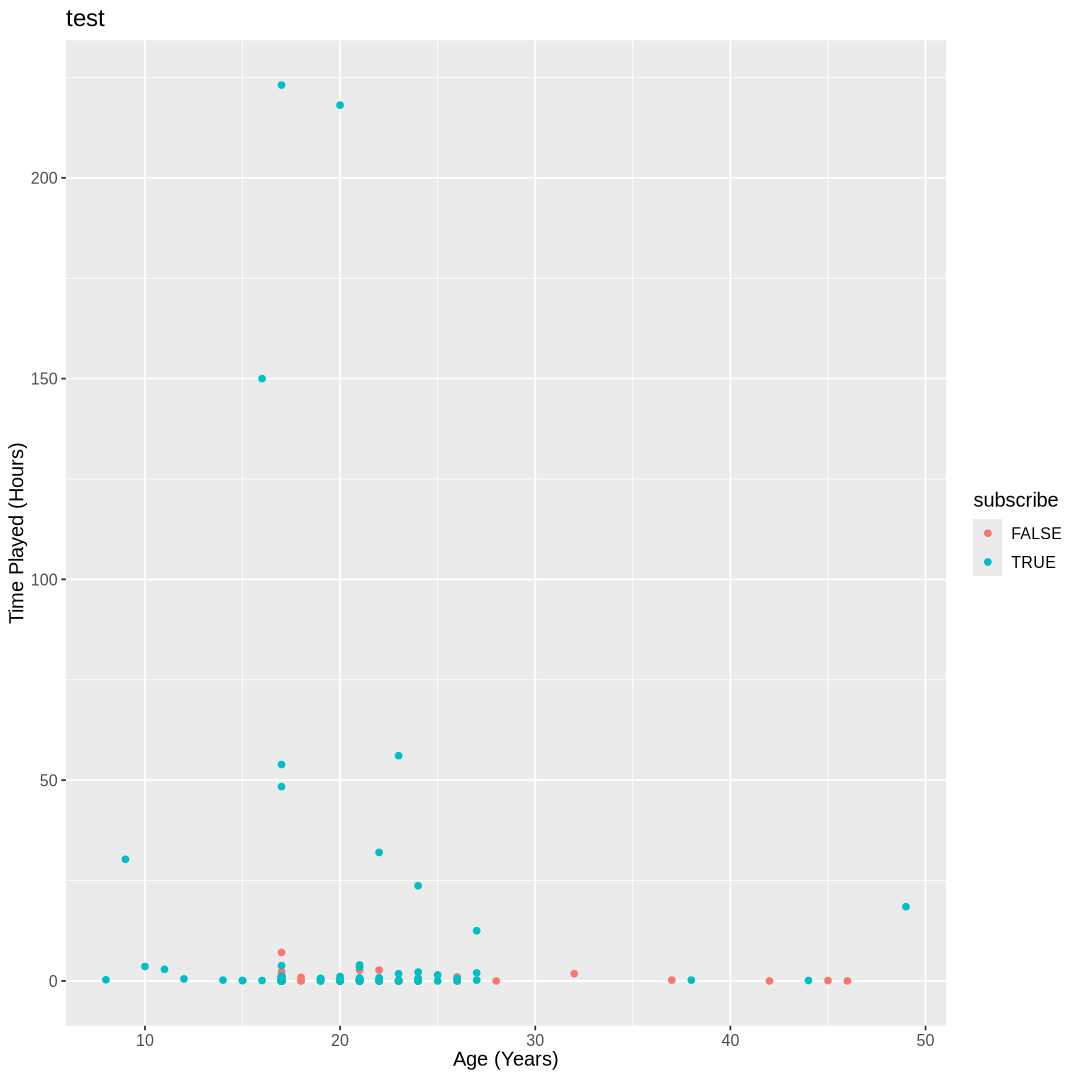

In [25]:
players_split <- initial_split(players, prop = 0.75, strata = subscribe)  
players_training <- training(players_split)
players_testing <- testing(players_split)

players_training

players_training_scaled <- 

test <- ggplot(players_training, aes(x = Age, y = played_hours, color = subscribe)) +
  geom_point() +
  labs(x = "Age (Years)", 
       y = "Time Played (Hours)", 
       title = "test") +
  theme(text = element_text(size = 12))

test

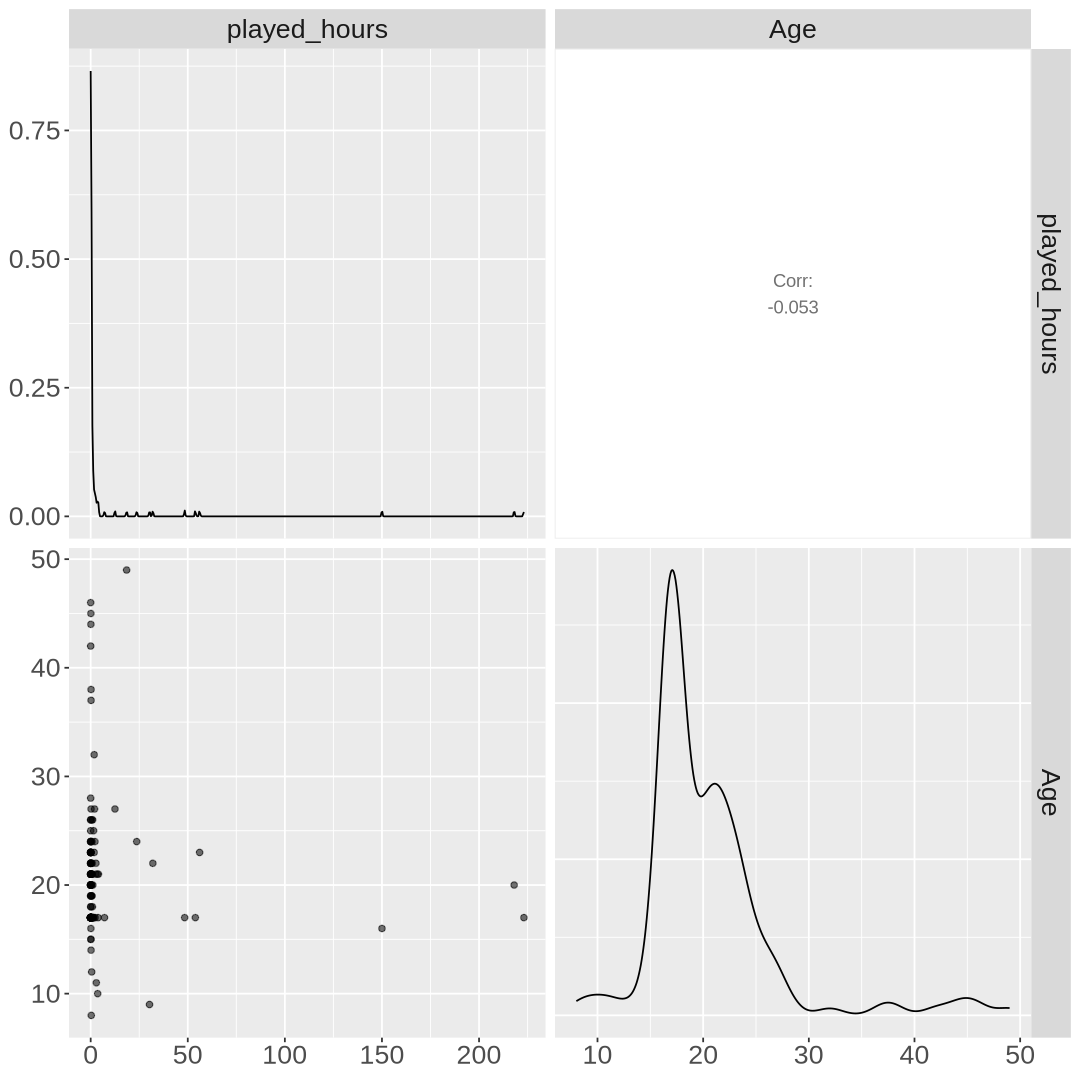

In [26]:
answer2.2 <- players_training |> 
    select(played_hours, Age) |>
    ggpairs(mapping = aes(alpha = 0.4)) +
    theme(text = element_text(size = 20))
answer2.2

# remove outliers

Creating the Model

In [5]:
players_recipe <- recipe(subscribe ~ played_hours + Age, data = players_training) |>
   step_scale(all_predictors()) |>
   step_center(all_predictors())

In [6]:
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

players_vfold <- vfold_cv(players_training, v = 5, strata = subscribe)
k_vals <- tibble(neighbors = seq(from = 1, to = 6, by = 1))

knn_tune_fit <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(knn_tune) |>
    tune_grid(resamples = players_vfold, grid = k_vals) |>
    collect_metrics()

Analysis of Tuning

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.5586700,5,0.01941480,Preprocessor1_Model1
2,accuracy,binary,0.5448768,5,0.02480094,Preprocessor1_Model2
3,accuracy,binary,0.5722167,5,0.01811683,Preprocessor1_Model3
4,accuracy,binary,0.5784072,5,0.02815446,Preprocessor1_Model4
5,accuracy,binary,0.6276519,5,0.02920252,Preprocessor1_Model5
6,accuracy,binary,0.6205090,5,0.02914624,Preprocessor1_Model6


[1] 5

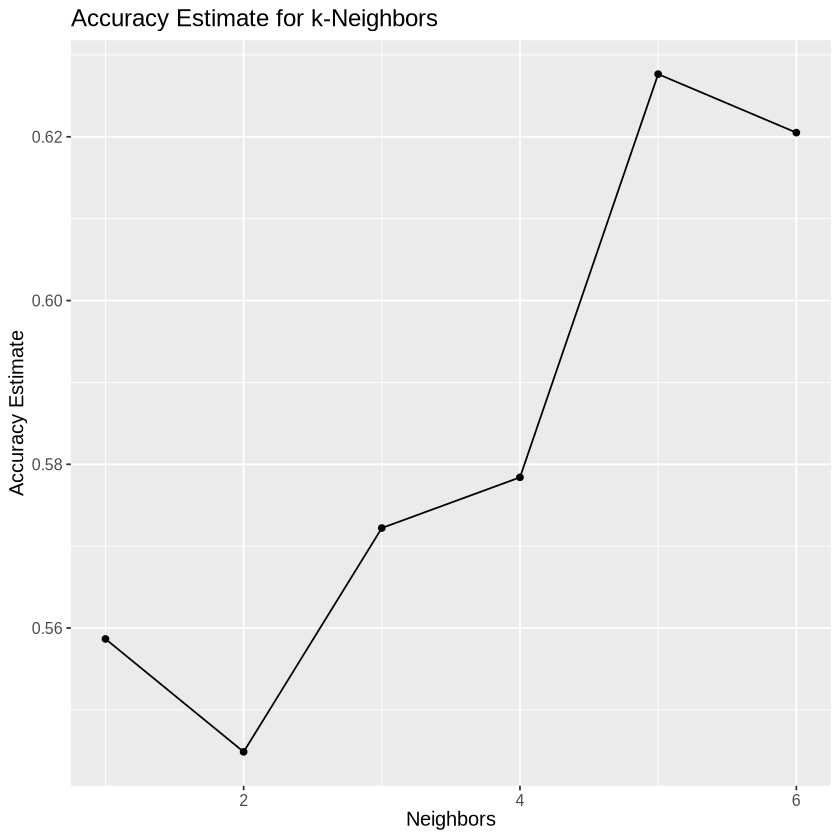

In [7]:
# compute the accuracy
accuracies <- knn_tune_fit |>
    filter(.metric == "accuracy")
accuracies

# find best k value
best_k <- accuracies |>
        arrange(desc(mean)) |>
        head(1) |>
        pull(neighbors)
best_k

accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", 
       y = "Accuracy Estimate", 
       title = "Accuracy Estimate for k-Neighbors") +
  theme(text = element_text(size = 12))

accuracy_vs_k

In [8]:
# Evaluating on the test set
knn_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) |>
  set_engine("kknn") |>
  set_mode("classification")

knn_best_fit <- workflow() |>
  add_recipe(players_recipe) |>
  add_model(knn_best_spec) |>
  fit(data = players_training)

In [9]:
# get predictions on the validation data
knn_best_fit_predictions <- predict(knn_best_fit, players_testing) |>
    bind_cols(players_testing)
knn_best_fit_predictions

knn_best_fit_accuracy <- knn_best_fit_predictions |>
    metrics(truth = subscribe, estimate = .pred_class) |>
    filter(.metric == "accuracy")
knn_best_fit_accuracy

confusion <- knn_best_fit_predictions |>
             conf_mat(truth = subscribe, estimate = .pred_class)
confusion

.pred_class,experience,subscribe,hashedEmail,played_hours,name,gender,Age
<fct>,<chr>,<fct>,<chr>,<dbl>,<chr>,<chr>,<dbl>
TRUE,Amateur,TRUE,8b71f4d66a38389b7528bb38ba6eb71157733df7d1740371852a797ae97d82d1,0.1,Natalie,Male,17
TRUE,Veteran,TRUE,7a4686586d290c67179275c7c3dfb4ea02f4d317d9ee0e2cee98baa27877a875,1.6,Lane,Female,23
TRUE,Regular,TRUE,5baba1651a0b92788bc0d6dcdf00be64af1cf9f0015bbeed204ddabd1d872e83,0.6,Kendall,Female,28
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
TRUE,Pro,FALSE,f7875ae87a61632030d5c4029ee8cf081be7047b2b4a9c04ab5a706f59786197,0.2,Liam,Male,17
FALSE,Regular,FALSE,8e98b6db2053af0bc0e62cd55bcea5a08f23986dec3d02ca520ea039517e6744,0.1,Sam,Male,18
TRUE,Veteran,FALSE,71453e425f07d10da4fa2b349c83e73ccdf0fb3312f778b35c5802c3292c87bd,0.3,Pascal,Male,22


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.6530612


          Truth
Prediction FALSE TRUE
     FALSE     7   11
     TRUE      6   25

Visualizing experience and gender to predict subscription to newletter, Bar Chart

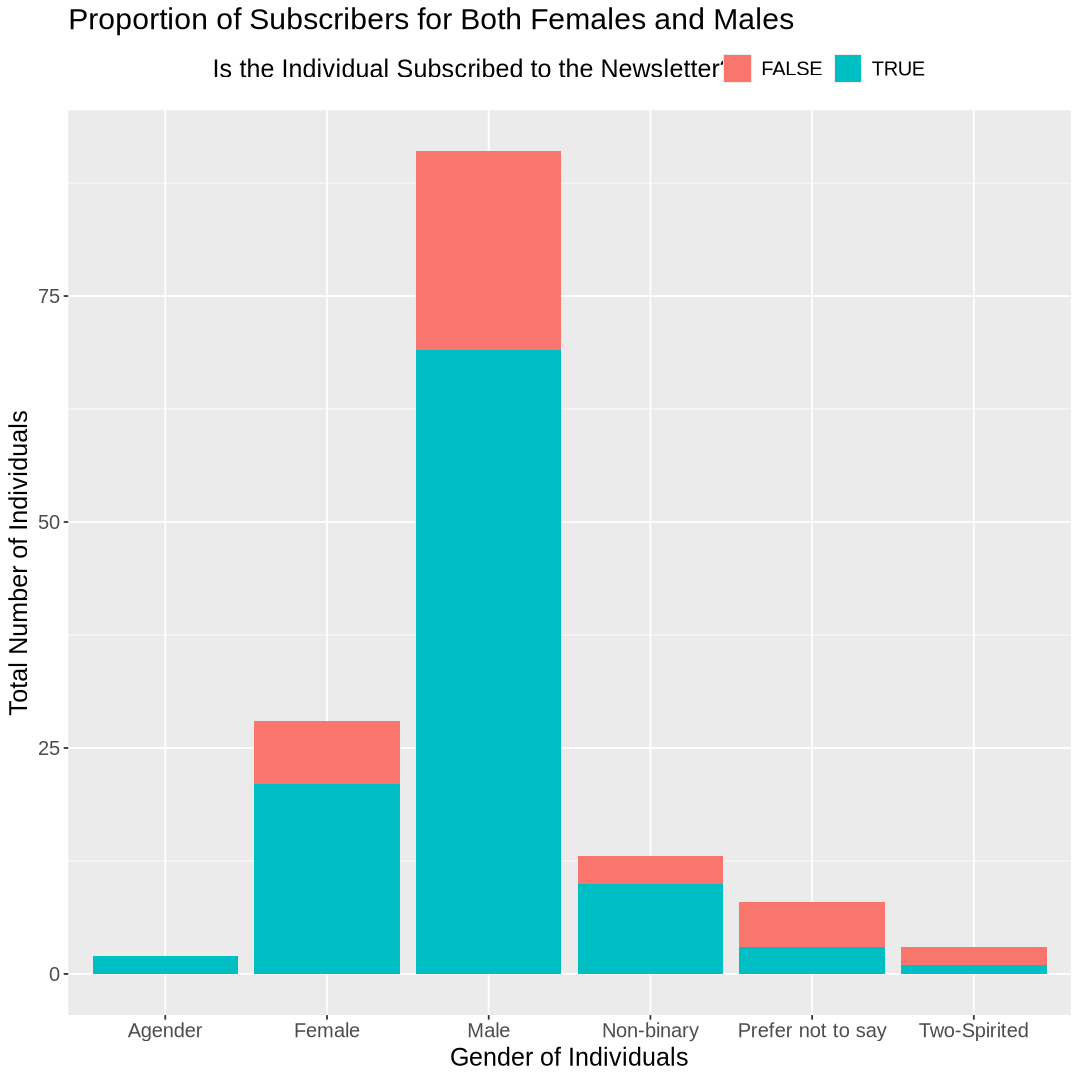

In [17]:
options(repr.plot.width = 9, repr.plot.height = 9)

gender_lot <- players_training |>
    ggplot(aes(x = gender, fill = subscribe)) + 
        geom_bar() +
        labs(x = "Gender of Individuals",
             y = "Total Number of Individuals",
             fill = "Is the Individual Subscribed to the Newsletter?") +
        ggtitle("Proportion of Subscribers for Both Females and Males") +
        theme(text = element_text(size = 15),
        legend.position = "top",
        legend.direction = "horizontal")

gender_lot

Analysis of Bar Plot

We cannot draw appropriate conclusions from individuals with agender, two-spirited, or unlisted genders.

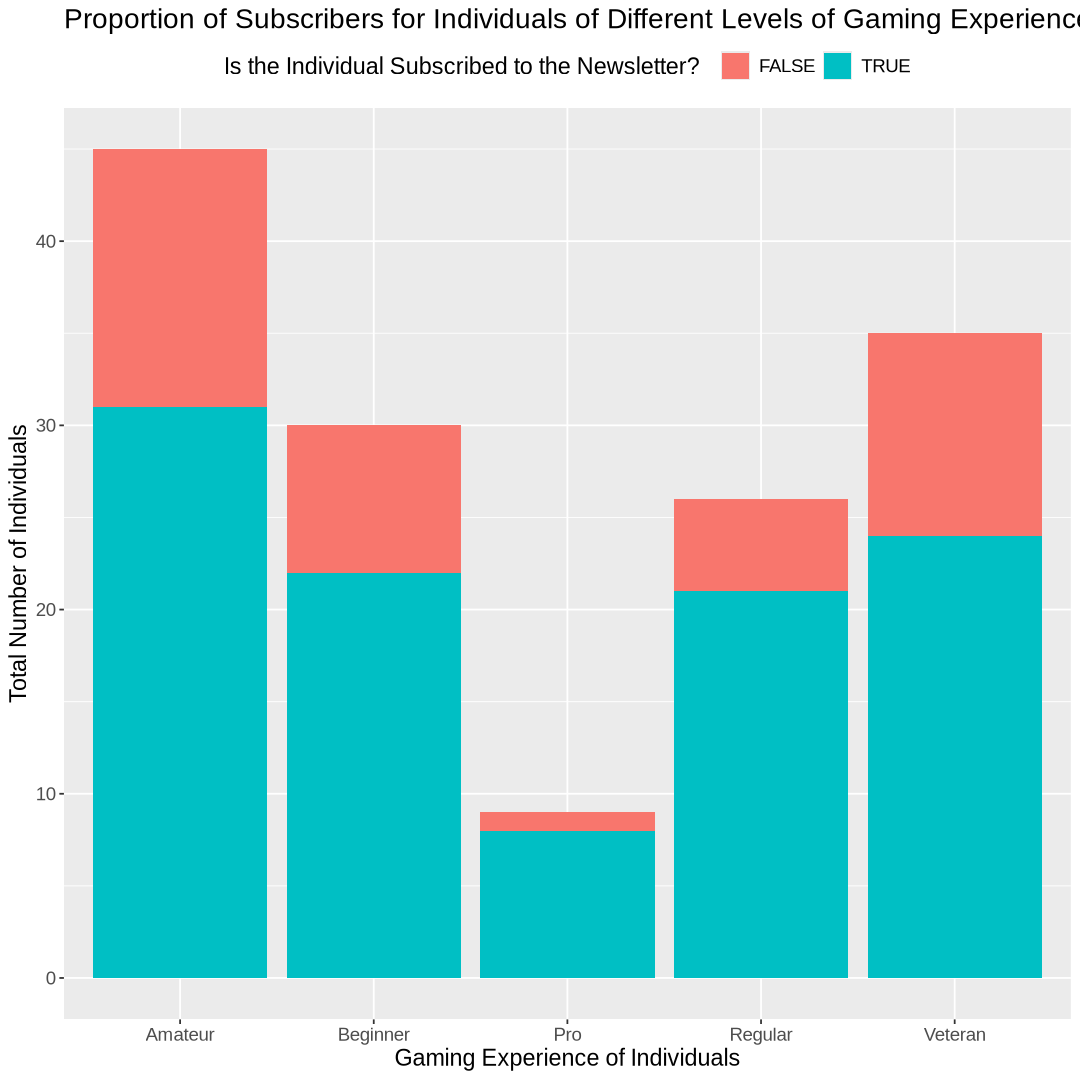

In [19]:
options(repr.plot.width = 9, repr.plot.height = 9)

gender_lot <- players_training |>
    ggplot(aes(x = experience, fill = subscribe)) + 
        geom_bar() +
        labs(x = "Gaming Experience of Individuals",
             y = "Total Number of Individuals",
             fill = "Is the Individual Subscribed to the Newsletter?") +
        ggtitle("Proportion of Subscribers for Individuals of Different Levels of Gaming Experience") +
        theme(text = element_text(size = 14),
        legend.position = "top",
        legend.direction = "horizontal")

gender_lot

Analysis of Bar Plot

In [ ]:
Pro level experience prodominantely subscribe to the newsletter.